# A/B TEST

## Goal:

The goal of this callenge is to analyze the result of an A/B test conducted in order to investigate why conversion rate of a worldwide company in Spain is much higher than in other LatAm countries. The test group of LatAm countries see a site version translated by a local, compared to the control group who see the original version translated from a Spaniard.

## Data

We have 2 tables for this challenge:

**test_table** - general information about the test results

**Columns:**

- **user_id** : the id of the user. Unique by user. Can be joined to user id in the other table.
For each user, we just check whether conversion happens the first time they land on the
site since the test started.

- **date** : when they came to the site for the first time since the test started

- **source** : marketing channel: Ads, SEO, Direct . Direct means everything except for ads
and SEO. Such as directly typing site URL on the browser, downloading the app w/o
coming from SEO or Ads, referral friend, etc.

- **device** : device used by the user. It can be mobile or web

- **browser_language** : in browser or app settings, the language chosen by the user. It can
be EN, ES, Other (Other means any language except for English and Spanish)

- **ads_channel** : if marketing channel is ads, this is the site where the ad was displayed. It
can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this
field is NA

- **browser** : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App,
Safari, Opera

- **conversion** : whether the user converted (1) or not (0). This is our label. A test is
considered successful if it increases the proportion of users who convert.

- **test** : users are randomly split into test (1) and control (0). Test users see the new
translation and control the old one. For Spain-based users, this is obviously always 0
since there is no change there



**user_table** - some information about the user

**Columns:**

- **user_id** : the id of the user. It can be joined to user id in the other table
- **sex :** user sex: Male or Female
- **age :** user age (self-reported)
- **country** : user country based on ip address

### Import dependencies

In [1]:
# Import main libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import Classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
# Import Model Evaluation tools
from sklearn.model_selection import train_test_split

In [4]:
# Import Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

In [5]:
# Import preprocessing tools
from sklearn.preprocessing import LabelEncoder, imputation, StandardScaler

### Read in the data

In [6]:
path = './user_table.csv'
user = pd.read_csv('user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
test = pd.read_csv('test_table.csv')

In [8]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


Check for duplicates in the two tables

In [9]:
user.duplicated().sum()

0

In [10]:
test.duplicated().sum()

0

Check if everyone in one table is also in the other one

In [11]:
len(user['user_id'].unique())==len(test['user_id'].unique())

False

Looks like the user table is busted and we have some user ids missing. When joining, we have to be
careful to do not lose the user ids in the test table, but not in the user table. Join the tables 

In [12]:
df = pd.merge(test, user, on = 'user_id', how = 'outer')

In [13]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


### Explore the joined dataset

In [14]:
df.shape

(453321, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [16]:
df.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [17]:
df.describe(include='O')

,date,source,device,browser_language,ads_channel,browser,sex,country
count,453321,453321,453321,453321,181877,453321,452867,452867
unique,5,3,2,3,5,7,2,17
top,2015-12-04,Ads,Web,ES,Facebook,Android_App,M,Mexico
freq,141163,181877,251565,377547,68425,155135,264485,128484


###### Some insights from the data

- Average conversion rate is roughly 4%. This is pretty normal. Considered to be industry standard.
- 47% of the population belong in the test group and 53% in the control group
- This is a fairly young user base with a mean age of 27 years. Also 75% of the user base is within 30 years of age.

### Data Cleaning

In [18]:
# print unique values of each column to gain high level perspective of the data
for col_name in df.columns:
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        print("They are:", df[col_name].unique(), '\n' )

Feature 'user_id' has 453321 unique categories
They are: [315281 497851 848402 ... 514870 785224 241662] 

Feature 'date' has 5 unique categories
They are: ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02'] 

Feature 'source' has 3 unique categories
They are: ['Direct' 'Ads' 'SEO'] 

Feature 'device' has 2 unique categories
They are: ['Web' 'Mobile'] 

Feature 'browser_language' has 3 unique categories
They are: ['ES' 'Other' 'EN'] 

Feature 'ads_channel' has 6 unique categories
They are: [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other'] 

Feature 'browser' has 7 unique categories
They are: ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera'] 

Feature 'conversion' has 2 unique categories
They are: [1 0] 

Feature 'test' has 2 unique categories
They are: [0 1] 

Feature 'sex' has 3 unique categories
They are: ['M' 'F' nan] 

Feature 'age' has 53 unique categories
They are: [32. 21. 34. 22. 19. 35. 31. 33. 37. 29. 28. 27. 39. 24. 20. 45. 23. 26.
 18. 25. 

### Exploratory Data Analysis (EDA)

In [19]:
# plotting settings
plt.style.use("ggplot")
figsize=(20,6)

###### Examine labels distribution 

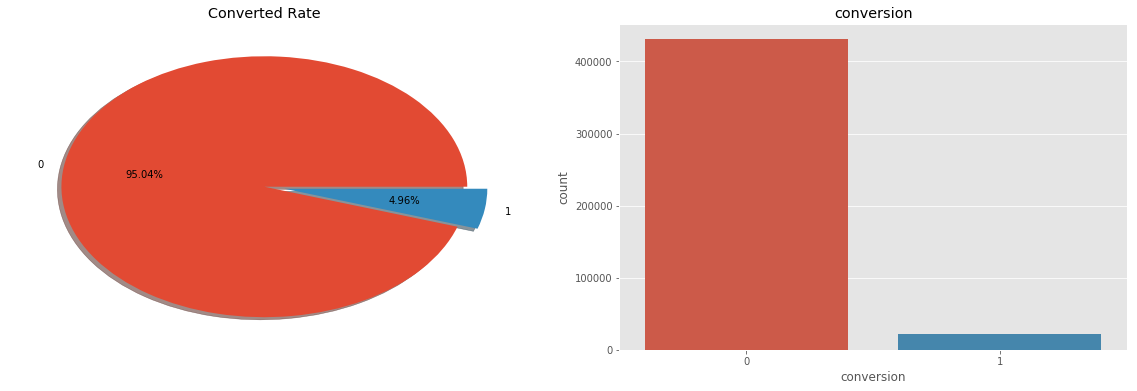

In [20]:
f, ax = plt.subplots(1,2,figsize=figsize)
df['conversion'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%',ax=ax[0],shadow=True)
ax[0].set_title('Converted Rate')
ax[0].set_ylabel('')
sns.countplot('conversion', data=df, ax=ax[1])
ax[1].set_title('conversion');

Let's ascertain that Spain conversion rate is much higher than any other LatAm country

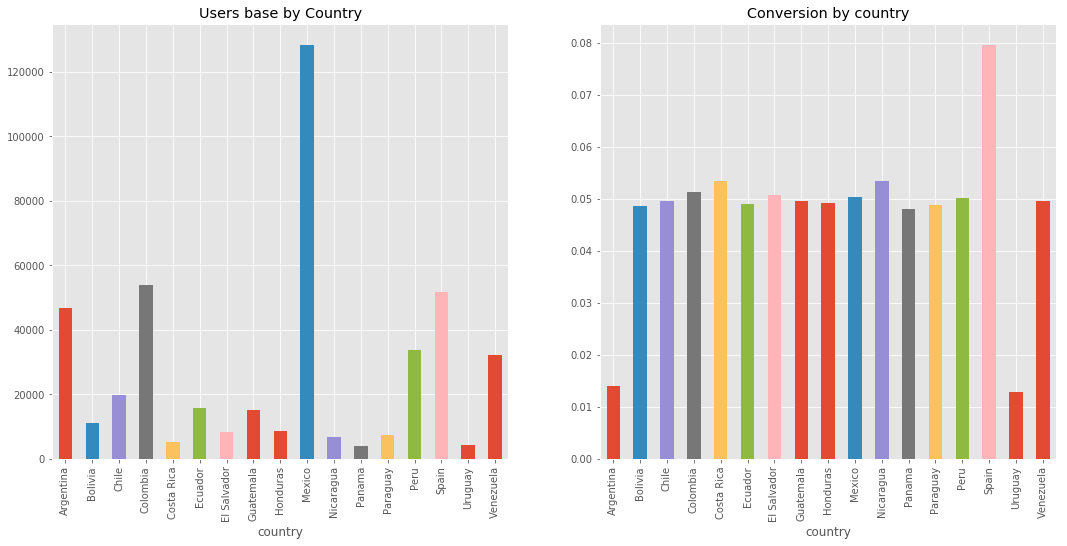

In [21]:
f, ax = plt.subplots(1,2,figsize=(18,8))
df.groupby('country')['conversion'].count().plot.bar(ax=ax[0])
ax[0].set_title('Users base by Country')
df.groupby('country')['conversion'].mean().plot.bar()
ax[1].set_title('Conversion by country');

That is true. Also we can notice something worth of attention, which is the conversion rate of Uruguay and Venezuela considerably lower than any other country. In fact from the leftmost diagram drawn above we can see that conversion rate is kind of stable for any other country, except Spain of course.

Sex does not appear to be a discriminative variable.

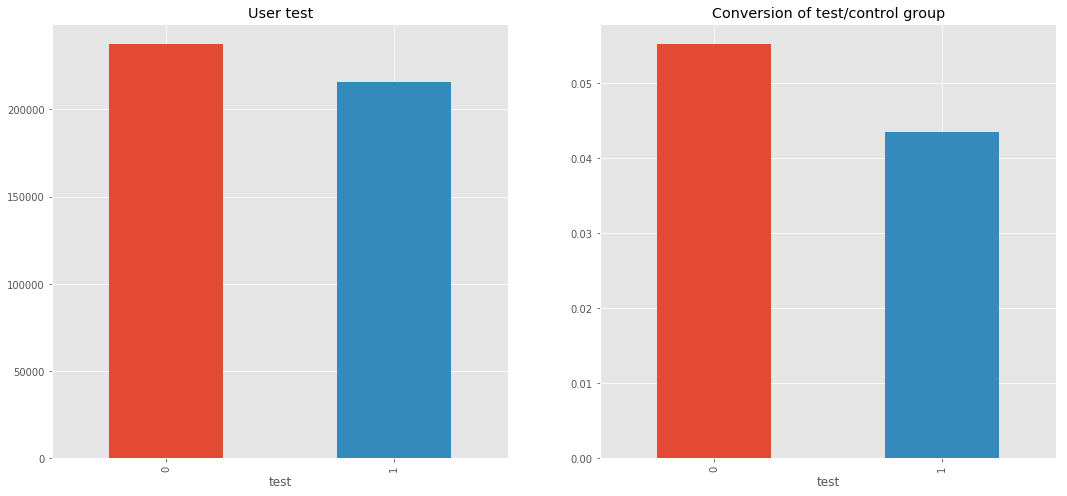

In [22]:
f,ax= plt.subplots(1,2, figsize=(18,8))
df.groupby('test').conversion.count().plot.bar(ax=ax[0])
ax[0].set_title('User test')
df.groupby('test').conversion.mean().plot.bar(ax=ax[1])
ax[1].set_title('Conversion of test/control group');

In [23]:
df.groupby('test')['conversion'].mean()

test
0    0.055179
1    0.043425
Name: conversion, dtype: float64

As assert on the introduction the test has been conducted splitting in a half the users. Let's verify that this is true

In [24]:
df.test.sum()/len(df.test)# ~50/50 test/control observations

0.47644605037048804

Let's make a working copy deprived of Spain, because no sense in keeping Spain considered no changes occurred

In [25]:
df_new = df.copy() 

In [26]:
df_new = df_new[df_new.country!='Spain'].copy()

In [27]:
df_new.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


Let's compare conversion rate between control group and test group

In [28]:
df_new.groupby('test')['conversion'].mean()*100 # percentage of conversion reduced for the test group

test
0    4.833042
1    4.342471
Name: conversion, dtype: float64

The data show a drop in CR for test group(i.e. LatAm countries whose users have seen a site version translated by a local citizen) and control group (i.e. LatAm countries whose users have seen a site version translated by a Spaniard citizen).
That sounds counterintuitive, we would expect the exact opposite. That is why the T-test is been conducted. These results require a deeper investigation. Let's start calculating p-value for this test.

In [29]:
import scipy  as sc
zero = df_new[df_new['test'] == 0]
one = df_new[df_new['test'] == 1]

sc.stats.ttest_ind(zero['conversion'], one['conversion'], equal_var = False, axis = 0)

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)

**p-value greater less than 0.05**, so the test is statistically significant. We have to be sure as wel that sample size has been collected in a sufficient quantity and that the split of initial data between test and control group has been performed randomly, in order not to introduce any bias. 

Let's perform a z-test using a software like G*Power, setting 'difference between two indipendent proportions' and computing 'required sample size' given α, power and effect size.

Inputing one tail, p1=0.0484, p2=0.0.0434, α=0.05, power=0.8, allocation ratio N2/N1 =1, we obtain a total total sample size of ca 44000.

In [30]:
len(zero)

185556

In [31]:
len(one)

215983

As clearly visible from the number of samples the criteria has been met, therefore the sample size is correct. We have only to check if the split has been randomized correctly. 

One way to do that is to build a decision tree where variables are the user dimension and the outcome variable is whether the user is in test or control. If the tree splits, that means that for given values of that variable you are more likely to end up in test or control. If randomization worked, the tree should not split at all (or at least not to be able to separate the class well.

### Data processing for Machine Learning Analysis

###### Create Feature Matrix X

In [32]:
X = df_new.drop(['conversion','date','test', 'user_id', 'age'], axis = 1)
X.shape

(401539, 7)

###### Label encoding of categorical variables¶

In [33]:
for feature in X.select_dtypes(include = ['O']).columns.values: # loop through all the feature spaces and pick only the catvars
    X[feature] = X[feature].factorize()[0]
X.head()

,source,device,browser_language,ads_channel,browser,sex,country
1,0,0,0,0,0,0,0
3,0,1,1,1,1,1,0
4,0,0,0,0,2,0,0
5,1,1,0,-1,1,1,1
6,2,1,1,-1,1,0,0


In [34]:
X.info()# final check on feature matrix X values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401539 entries, 1 to 453320
Data columns (total 7 columns):
source              401539 non-null int64
device              401539 non-null int64
browser_language    401539 non-null int64
ads_channel         401539 non-null int64
browser             401539 non-null int64
sex                 401539 non-null int64
country             401539 non-null int64
dtypes: int64(7)
memory usage: 24.5 MB


###### Create response vector y 

In [35]:
y = df_new['test']

### Decision Tree Classifier

In [36]:
tree = DecisionTreeClassifier(random_state=0, criterion = 'entropy', max_depth = 3)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [37]:
export_graphviz(tree, out_file='tree.dot', feature_names=X.columns, class_names=['Control Group', 'TEST Group'],
               impurity=False, filled=True, node_ids= True, proportion=True, rounded=True)

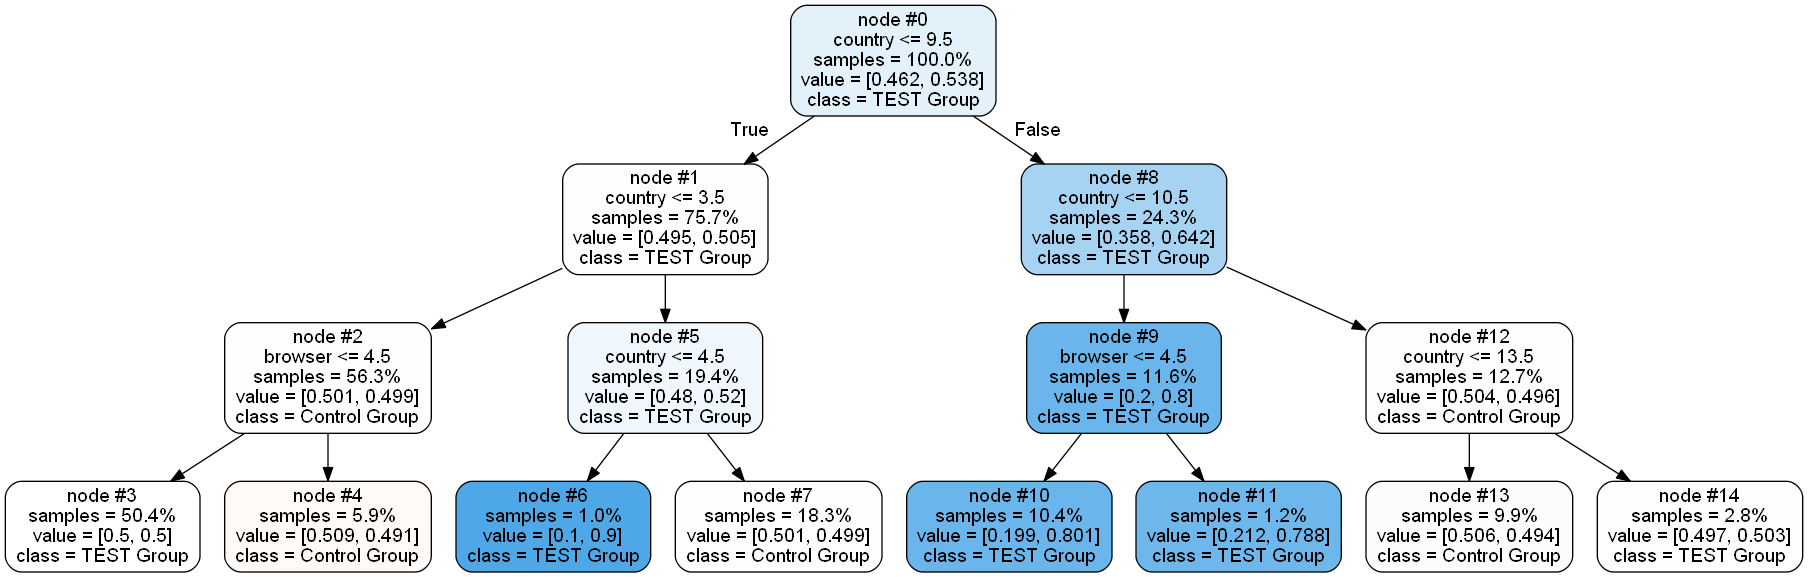

In [38]:
from IPython.display import Image
Image(filename='tree.png') 

The tree can in fact split. Going down to the leaves is easy to determine that countries identified by number 4 and 10 contain a higher value for test, showing that the vast majority of the users belonging to those countries ended up in the test group. 

On the contrary the other users have been correctly split almost in a half in the two groups. The fact that users of these two countries ended up mostly in the user group might have a high influence on final test reasult, in particular if their conversion rate is somewhat different from the average of other countries. Let's find out which countries are we talking about.

In [39]:
X[X.country==10].head()

,source,device,browser_language,ads_channel,browser,sex,country
31,0,0,0,1,0,1,10
49,2,0,0,-1,5,0,10
57,1,0,0,-1,0,1,10
58,2,0,2,-1,5,0,10
73,1,1,0,-1,1,1,10


In [40]:
df_new.loc[df_new.index == 31, :]

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
31,730926,2015-11-30,Ads,Web,ES,Facebook,IE,0,0,F,26.0,Argentina


In [41]:
X[X.country==4].head()

,source,device,browser_language,ads_channel,browser,sex,country
11,2,0,0,-1,0,1,4
20,0,1,2,1,4,1,4
61,0,0,0,0,3,0,4
200,2,1,0,-1,1,0,4
207,0,0,0,4,3,1,4


In [42]:
df_new.loc[df_new.index == 11, :]

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
11,73335,2015-12-03,SEO,Web,ES,NaN,IE,0,1,F,29.0,Uruguay


As we can see the two countries are Uruguay and Argentina, which we previously noticed have in fact a lower conversion rate compared to all the others. No surprise then that the test group mean has been pulled down by these values.

Another tool we can use to double check the correctness of our analysis is to estimate feature importances of DT

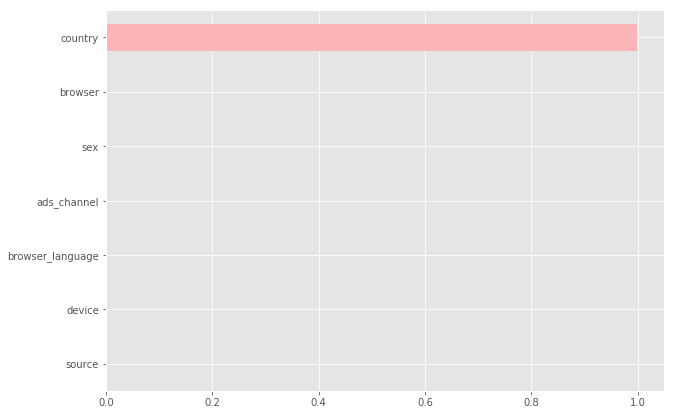

In [43]:
feature_importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values().plot(kind='barh', figsize=(10,7))

The diagram clearly confirms the fact that country is the only variable used to split. Once again, this confirms that the sample is biased. If the group had been created properly no variable would have shown a great importance over the others.

As a side exercise we can segment by country and determine the p-value for each country.

In [44]:
a = df_new.groupby(['country','test'])[['conversion']].mean().unstack()
b = df_new.groupby('country')[['test']].mean()
data = pd.concat([a,b], axis = 1)

temp1 = df_new[df_new['test'] == 0]
temp2 = df_new[df_new['test'] == 1]

a = []; b = []; c = []; d = []

for i, j in temp1.groupby('country')['conversion']:
    a.append(i)
    b.append(j)
for i, j in temp2.groupby('country')['conversion']:
    c.append(i)
    d.append(j)
    
p_value = []
for i in np.arange(16):
    p_value.append(sc.stats.ttest_ind(b[i], d[i], equal_var = False, axis = 0)[1])    
    
data = pd.concat([data, pd.DataFrame(p_value, index = a)], axis = 1)

data.columns = ['mean in control', 'mean in test', '%samples in test group', 'p_value']
data

,mean in control,mean in test,%samples in test group,p_value
country,,,,
Argentina,0.015071,0.013725,0.799799,0.335147
Bolivia,0.049369,0.047901,0.501079,0.718885
Chile,0.048107,0.051295,0.500785,0.302848
Colombia,0.052089,0.050571,0.498927,0.423719
Costa Rica,0.052256,0.054738,0.498964,0.687876
Ecuador,0.049154,0.048988,0.494432,0.961512
El Salvador,0.053554,0.047947,0.497492,0.248127
Guatemala,0.050643,0.048647,0.496066,0.572107
Honduras,0.050906,0.047540,0.491013,0.471463


As it can be seen the p-value associated with all the countries is much greater than 0.05. This implies that we fail to reject the null hypothesis. Thus, there is no statistically significant difference in means between test and control group in each country.

### Conclusions

- As it can be seen Argentina and Uruguay have the lowest conversion rate of 1%. Also, nearly 80% of the samples from these two countries found it's way into the test group and only 20% in the control group.


- Due to their small conversion rate and massive influx of samples into the test group, there was a significant difference between the overall test conversion and control conversion rates. It was because of this the mean of the test group was much less than the mean of the control group.


- However, it is now clear that the **A/B test was insignificant**. Both the test and the control group perform similarly. It is clear that the local translation did not affect the conversion rate.